# Fantasy Football Lineups Generator (Euro 2020)
* Data was collected from various sources including eurofantasy.sport5 (stats, names, prices), whoscored (stats of previouse tournaments), oddschecker (betting odds) and more.

sources:

https://eurofantasy.sport5.co.il/

https://www.whoscored.com/Regions/247/Tournaments/124/International-European-Championship

https://www.oddschecker.com/football/euro-2020/winner

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Load Data and review it
*pre-tournament

### Teams data
1. name_h - team hebraw name (str)
2. name_e - team english name (str)
3. theguardian_pr - power ranking extracted from "The Guardian" website. (int: 1->24)
4. fifa_ranking - ordered list of teams by fifa ranking. (int: 1->24)
5. reddit1_pr - power ranking extracted from a sub-reddit. (int: 1->24) 
6. reddit2_pr - another power ranking extracted from a sub-reddit. (int: 1->24)
7. my_pr - my personal power ranking of teams. (int: 1->24)
8. bets_odds - average betting odds (for winning the tournament) extracted from oddschecker. (float: >0 )
9. form_last6 - from of the team in the last 6 games (from left to right), W-Win, D-Draw, L-Lose. (str)
10. gfpg - Goals For per Game - qualifiers round. (float: >=0)
10. gapg - Goals Against per Game - qualifiers round. (float: >=0)

In [72]:
teams_df = pd.read_csv('data/teams.csv', encoding='utf-8')
teams_df.head()

,name_h,name_e,theguardian_pr,fifa_ranking,reddit1_pr,reddit2_pr,my_pr,bets_odds,form_last6,gfpg,gapg
0,צרפת,France,1,2,1,1,2,4.68,WWWDWW,2.500,0.600
1,אנגליה,England,4,3,8,9,1,5.03,WWWWWL,4.625,0.750
2,בלגיה,Belgium,3,1,2,6,5,6.20,WDWWWW,4.000,0.300
3,ספרד,Spain,10,5,5,3,7,7.87,WWDWDD,3.100,0.500
4,גרמניה,Germany,2,8,9,4,3,7.93,DLWWLW,3.750,0.875


### Players data
1. name_h - player hebraw name (str)
2. name_e - player english name (str)
3. team - player's team name - hebraw (str)
4. is_penalty_taker - indicates if the player is his team penaly taker. (int: binary - 0/1)
5. is_starter - indicates if player is in the starting XI of its team. (int: binary - 0/1) ** NOT IN USE DUE TO PARTIAL DATA **

In [73]:
players_df = pd.read_csv('data/players.csv', encoding='utf-8')  # TODO - add players
players_df.head()

,name_h,name_e,team,is_penalty_taker,is_starter
0,אלכסנדר שלאגר,Alexander Schlager,אוסטריה,0,1
1,דניאל באכמן,NaN,אוסטריה,0,0
2,פאבאו פרבאן,Pavao Pervan,אוסטריה,0,0
3,אלכסנדר דרגוביץ',Aleksandar Dragovic,אוסטריה,0,1
4,אנדראס אולמר,Andreas Ulmer,אוסטריה,0,0


### Players stats (from whoscored.com)
*all stats below are calculated on last 2 international tournaments.
1. Player - player name in english (str)
2. Apps - appearances (int: >=0)
3. Mins - minutes played (int: >=0)
3. Goals
4. Assists
5. SpG - Shots per Game
6. Rating - whoscored rating 
7. Apps_percentage - appearances percentage out of the maximum number of appearances for the team.
8. Mins_percentage - minutes percentage out of the maximum number of minutes played for the team.
9. Goals_percentage - goals scored by player out of all the goals of the team.
10. Assists_percentage - goals assisted by player out of all the goals assisted of the team.
11. GnA_percentage - goals scored and assisted by player out of all the goals scored and assisted of the team.

In [74]:
players_stats_df = pd.read_csv('data/players_stats.csv', encoding='utf-8')
convert_dict = {'Player': str,
                'Apps': int,
                'Mins': int,
                'Goals': int,
                'Assists': int,
                'SpG': float,
                'Rating': float,
                'Apps_percentage': float,
                'Mins_percentage': float,
                'Goals_percentage': float,
                'Assists_percentage': float,
                'GnA_percentage': float}
players_stats_df = players_stats_df.astype(convert_dict)
players_stats_df.head()

,Player,Apps,Mins,Goals,Assists,SpG,Rating,Apps_percentage,Mins_percentage,Goals_percentage,Assists_percentage,GnA_percentage
0,Agim Ibraimi,0,2,0,0,0.00,6.120,0.000,0.003,0.000,0.0,0.000
1,Aleksandar Trajkovski,6,450,3,0,1.75,6.955,0.667,0.594,0.176,0.0,0.111
2,Arijan Ademi,3,275,1,1,1.00,7.045,0.333,0.363,0.059,0.1,0.074
3,Boban Nikolov,6,493,0,0,1.05,6.670,0.667,0.650,0.000,0.0,0.000
4,Damjan Siskovski,5,469,0,0,0.00,6.680,0.556,0.619,0.000,0.0,0.000


### Load players game data

In [75]:
round1_file_path = 'data/raw/2021-06-06-r1.html'
data = pd.read_html(round1_file_path)

In [76]:
gaolkeepers_columns_renames = {"שוער": "name", "מחיר": "price", "נק’": "points"}
gaolkeepers_df = data[7].rename(columns=gaolkeepers_columns_renames)
gaolkeepers_df['position'] = 'GK'
del gaolkeepers_df['Unnamed: 3']

In [77]:
defenders_columns_renames = {"הגנה": "name", "מחיר": "price", "נק’": "points"}
defenders_df = data[8].rename(columns=defenders_columns_renames)
defenders_df['position'] = 'D'
del defenders_df['Unnamed: 3']

In [78]:
midfielders_columns_renames = {"קישור": "name", "מחיר": "price", "נק’": "points"}
midfielders_df = data[9].rename(columns=midfielders_columns_renames)
midfielders_df['position'] = 'M'
del midfielders_df['Unnamed: 3']

In [79]:
forwards_columns_renames = {"התקפה": "name", "מחיר": "price", "נק’": "points"}
forwards_df = data[10].rename(columns=forwards_columns_renames)
forwards_df['position'] = 'FW'
del forwards_df['Unnamed: 3']

In [80]:
players_gamedata_df = pd.concat([gaolkeepers_df, defenders_df, midfielders_df, forwards_df], ignore_index=True)
players_gamedata_df['team'] = players_gamedata_df['name'].apply(lambda x: ((x.split('('))[1].split(")"))[0])
players_gamedata_df['name'] = players_gamedata_df['name'].apply(lambda x: ((x.split('('))[0])[:-1])
players_gamedata_df['price'] = players_gamedata_df['price'].apply(lambda x: (x.split('.'))[0]).astype('int')

In [81]:
players_gamedata_df.head()

,name,price,points,position,team
0,הוגו לוריס,10,0,GK,צרפת
1,אונאי סימון,9,0,GK,ספרד
2,טיבו קורטואה,9,0,GK,בלגיה
3,מנואל נוייר,9,0,GK,גרמניה
4,ג'אנלואיג'י דונארומה,8,0,GK,איטליה


### Load matches data (rounds 1 to 3)

In [82]:
matches_columns_renames = {"תאריך": "date", "שעה": "hour", "קבוצה מארחת": "home_team", "תוצאה": "score", "קבוצה אורחת": "away_team", "סקירה": "review"}
round1_matches_df = data[0].rename(columns=matches_columns_renames)
round1_matches_df['date'] = pd.to_datetime(round1_matches_df['date'], format="%d.%m.%Y")
del round1_matches_df['hour']
del round1_matches_df['review']

In [83]:
round2_file_path = 'data/raw/2021-06-06-r2.html'
data = pd.read_html(round2_file_path)
round2_matches_df = data[0].rename(columns=matches_columns_renames)
round2_matches_df['date'] = pd.to_datetime(round2_matches_df['date'], format="%d.%m.%Y")
del round2_matches_df['hour']
del round2_matches_df['review']

In [84]:
round3_file_path = 'data/raw/2021-06-06-r3.html'
data = pd.read_html(round3_file_path)
round3_matches_df = data[0].rename(columns=matches_columns_renames)
round3_matches_df['date'] = pd.to_datetime(round3_matches_df['date'], format="%d.%m.%Y")
del round3_matches_df['hour']
del round3_matches_df['review']

In [85]:
round3_matches_df.head()

,date,home_team,score,away_team
0,2021-06-20,איטליה,---,וויילס
1,2021-06-20,שווייץ,---,טורקיה
2,2021-06-21,אוקראינה,---,אוסטריה
3,2021-06-21,צפון מקדוניה,---,הולנד
4,2021-06-21,פינלנד,---,בלגיה


## Feature engineering
* I'll create a general PR (power rank) score for each team based on combination of other power ranks sources, betting odds and form.
* based on the above and considering GFpG (Goals For per Game) and GApG (Goals Against per Game) i'll try to estimate the score for each match.
* based on the estimated score of each match and the scoring rules of the game, i'll try to estimate how much game points each player "worth" every round.

### Team features

* form - accumulated points according to form of last 6 matches. normalized to (0,1). higher is better.

In [86]:
teams_df['form'] =  3 * teams_df['form_last6'].str.count('W') +  teams_df['form_last6'].str.count('D')
minimum = teams_df['form'].min()
maximum = teams_df['form'].max()
teams_df['form'] = (teams_df['form'] - minimum)/(maximum - minimum)
teams_df.drop('form_last6', axis='columns', inplace=True)

* power_rank_avg - average of 5 different power ranking (detailed above). normalized to (0,1). higher is better.

In [87]:
power_rank_columns = ["theguardian_pr", "fifa_ranking", "reddit1_pr", "reddit2_pr", "my_pr"]
teams_df['power_rank_avg'] = teams_df[power_rank_columns].mean(axis=1)
minimum = teams_df['power_rank_avg'].min()
maximum = teams_df['power_rank_avg'].max()
teams_df['power_rank_avg'] = (teams_df['power_rank_avg'] - minimum)/(maximum - minimum)
teams_df['power_rank_avg'] = 1 - teams_df['power_rank_avg']
teams_df.drop(power_rank_columns, axis='columns', inplace=True)

* bets_odds - average betting odds (detailed above). normalized to (0,1). higher is better.

In [88]:
minimum = teams_df['bets_odds'].min()
maximum = teams_df['bets_odds'].max()
teams_df['bets_odds'] = (teams_df['bets_odds'] - minimum)/(maximum - minimum)
teams_df['bets_odds'] = 1 - teams_df['bets_odds']

* weighted_sum_pr - power rank that is a wighted sum of form, power_rank_avg and bets_odds. note that the weight of bet odds is significantly higher. it's probably the most accurate representation of the ranking between teams.

In [89]:
w_bets_odds = 0.5
w_power_rank_avg = 0.3
w_form = 0.2
w_power = 1.4
teams_df['weighted_sum'] = (w_bets_odds * teams_df['bets_odds']) + (w_power_rank_avg * teams_df['power_rank_avg']) + (w_form * teams_df['form'])
teams_df['weighted_sum'] = np.power(teams_df['weighted_sum'], w_power)

* gfpg, gapg - Goals For/Against per Game. I tweeked it to represent more accurately the harder match-ups in the tournament (relitivly to qulifiers, where gfpg and gapg were recorded). 

In [90]:
teams_df['gfpg'] = 0.8 * teams_df['gfpg']
teams_df['gapg'] = 1.2 * teams_df['gapg']

In [91]:
cols = ['bets_odds', 'form', 'power_rank_avg', 'weighted_sum']
teams_df[cols] = teams_df[cols].round(3)
teams_df.head()

,name_h,name_e,bets_odds,gfpg,gapg,form,power_rank_avg,weighted_sum
0,צרפת,France,1.000,2.00,0.72,0.846,1.000,0.957
1,אנגליה,England,0.999,3.70,0.90,0.769,0.838,0.869
2,בלגיה,Belgium,0.997,3.20,0.36,0.846,0.910,0.918
3,ספרד,Spain,0.993,2.48,0.60,0.538,0.793,0.786
4,גרמניה,Germany,0.993,3.00,1.05,0.385,0.829,0.760


In [92]:
teams_df.describe()

,bets_odds,gfpg,gapg,form,power_rank_avg,weighted_sum
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,0.757958,1.905556,0.989167,0.461500,0.500000,0.541958
std,0.306190,0.750427,0.408964,0.290342,0.300565,0.288324
min,0.000000,1.000000,0.360000,0.000000,0.000000,0.028000
25%,0.721750,1.295000,0.690000,0.211750,0.274500,0.390750
50%,0.852500,1.770000,0.930000,0.500000,0.495500,0.586000
75%,0.989000,2.325000,1.110000,0.634250,0.802000,0.766500
max,1.000000,3.700000,2.000000,1.000000,1.000000,0.957000


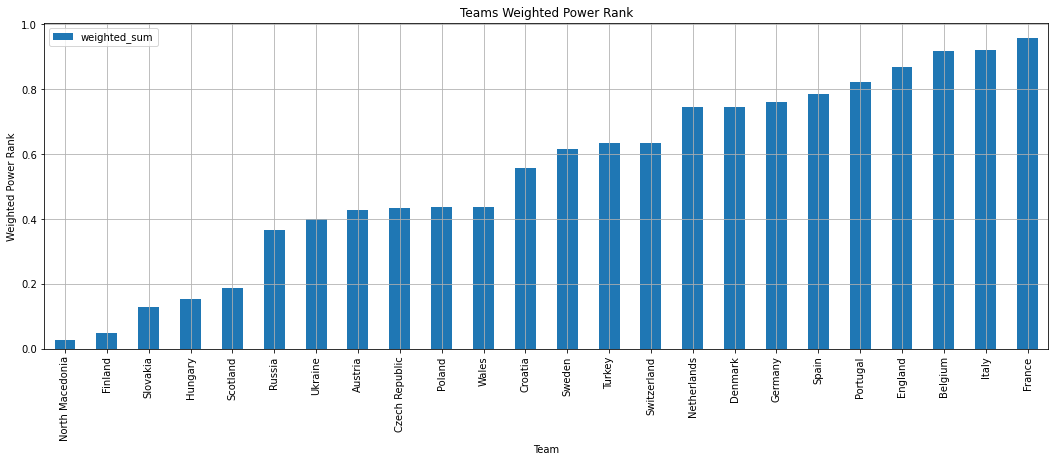

In [93]:
teams_df.sort_values("weighted_sum", inplace=True)
teams_df.plot(x="name_e", y=["weighted_sum"], kind="bar", figsize=(18,6));
plt.grid();
plt.xticks(rotation=90);
plt.title('Teams Weighted Power Rank');
plt.xlabel('Team');
plt.ylabel('Weighted Power Rank');

### Get opponents for every round and estimate match outcome

In [94]:
pr_diff_wight = 1.3
def calc_GF(x):
    numenator = x.gfpg + x.opponent_gapg
    denuminator = 2 - pr_diff_wight * x.pr_diff
    return numenator / denuminator

def calc_GA(x):
    numenator = x.gapg + x.opponent_gfpg
    denuminator = 2 + pr_diff_wight * x.pr_diff
    return numenator / denuminator

#### Round 1 matches

In [95]:
opponents1_df = round1_matches_df[['home_team', 'away_team']].set_index('home_team')
opponents2_df = round1_matches_df[['home_team', 'away_team']].set_index('away_team')
opponents_round1_df = pd.concat([opponents1_df, opponents2_df])
opponents_round1_df['opponent'] = opponents_round1_df.fillna('').sum(axis=1)
opponents_round1_df.drop(columns=['home_team', 'away_team'], inplace=True)

In [96]:
matches_round1_df = opponents_round1_df.merge(teams_df, left_index=True, right_on='name_h').set_index('name_h')
matches_round1_df.drop(columns=['name_e', 'bets_odds', 'power_rank_avg', 'form'], inplace=True)
matches_round1_df.rename(columns={'weighted_sum': 'pr'}, inplace=True)
matches_round1_df['opponent_pr'] = matches_round1_df.apply(lambda row: matches_round1_df.loc[row['opponent']].get('pr'), axis=1)
matches_round1_df['opponent_gfpg'] = matches_round1_df.apply(lambda row: matches_round1_df.loc[row['opponent']].get('gfpg'), axis=1)
matches_round1_df['opponent_gapg'] = matches_round1_df.apply(lambda row: matches_round1_df.loc[row['opponent']].get('gapg'), axis=1)
matches_round1_df['pr_diff'] = matches_round1_df['pr'] - matches_round1_df['opponent_pr']
matches_round1_df.drop(columns=['pr', 'opponent_pr'], inplace=True)

In [97]:
matches_round1_df['pred_GF'] = matches_round1_df.apply(lambda row: calc_GF(row), axis=1)
matches_round1_df['pred_GA'] = matches_round1_df.apply(lambda row: calc_GA(row), axis=1)
matches_round1_df['pred_score'] = matches_round1_df.apply(lambda row: (np.floor(row.pred_GF).astype(int), np.floor(row.pred_GA).astype(int)), axis=1)
matches_round1_df.head()

,opponent,gfpg,gapg,opponent_gfpg,opponent_gapg,pr_diff,pred_GF,pred_GA,pred_score
name_h,,,,,,,,,
טורקיה,איטליה,1.44,0.36,2.96,0.48,-0.287,0.809068,2.040691,"(0, 2)"
וויילס,שווייץ,1.00,0.90,1.90,0.90,-0.197,0.842161,1.605597,"(0, 1)"
דנמרק,פינלנד,2.30,0.90,1.28,1.20,0.699,3.207184,0.749476,"(3, 0)"
בלגיה,רוסיה,3.20,0.36,2.00,0.96,0.552,3.243918,0.868413,"(3, 0)"
אנגליה,קרואטיה,3.70,0.90,1.70,1.05,0.313,2.981608,1.080228,"(2, 1)"


#### Round 2 matches

In [98]:
opponents1_df = round2_matches_df[['home_team', 'away_team']].set_index('home_team')
opponents2_df = round2_matches_df[['home_team', 'away_team']].set_index('away_team')
opponents_round2_df = pd.concat([opponents1_df, opponents2_df])
opponents_round2_df['opponent'] = opponents_round2_df.fillna('').sum(axis=1)
opponents_round2_df.drop(columns=['home_team', 'away_team'], inplace=True)

In [99]:
matches_round2_df = opponents_round2_df.merge(teams_df, left_index=True, right_on='name_h').set_index('name_h')
matches_round2_df.drop(columns=['name_e', 'bets_odds', 'power_rank_avg', 'form'], inplace=True)
matches_round2_df.rename(columns={'weighted_sum': 'pr'}, inplace=True)
matches_round2_df['opponent_pr'] = matches_round2_df.apply(lambda row: matches_round2_df.loc[row['opponent']].get('pr'), axis=1)
matches_round2_df['opponent_gfpg'] = matches_round2_df.apply(lambda row: matches_round2_df.loc[row['opponent']].get('gfpg'), axis=1)
matches_round2_df['opponent_gapg'] = matches_round2_df.apply(lambda row: matches_round2_df.loc[row['opponent']].get('gapg'), axis=1)
matches_round2_df['pr_diff'] = matches_round2_df['pr'] - matches_round2_df['opponent_pr']
matches_round2_df.drop(columns=['pr', 'opponent_pr'], inplace=True)

In [100]:
matches_round2_df['pred_GF'] = matches_round2_df.apply(lambda row: calc_GF(row), axis=1)
matches_round2_df['pred_GA'] = matches_round2_df.apply(lambda row: calc_GA(row), axis=1)
matches_round2_df['pred_score'] = matches_round2_df.apply(lambda row: (np.floor(row.pred_GF).astype(int), np.floor(row.pred_GA).astype(int)), axis=1)
matches_round2_df.head()

,opponent,gfpg,gapg,opponent_gfpg,opponent_gapg,pr_diff,pred_GF,pred_GA,pred_score
name_h,,,,,,,,,
פינלנד,רוסיה,1.28,1.20,2.0,0.96,-0.319,0.927651,2.018545,"(0, 2)"
טורקיה,וויילס,1.44,0.36,1.0,0.90,0.196,1.340821,0.603158,"(1, 0)"
איטליה,שווייץ,2.96,0.48,1.9,0.90,0.286,2.370716,1.003457,"(2, 1)"
אוקראינה,צפון מקדוניה,1.70,0.60,1.0,1.40,0.371,2.042564,0.644564,"(2, 0)"
דנמרק,בלגיה,2.30,0.90,3.2,0.36,-0.172,1.196258,2.308039,"(1, 2)"


#### Round 3 matches

In [101]:
opponents1_df = round3_matches_df[['home_team', 'away_team']].set_index('home_team')
opponents2_df = round3_matches_df[['home_team', 'away_team']].set_index('away_team')
opponents_round3_df = pd.concat([opponents1_df, opponents2_df])
opponents_round3_df['opponent'] = opponents_round3_df.fillna('').sum(axis=1)
opponents_round3_df.drop(columns=['home_team', 'away_team'], inplace=True)

In [102]:
matches_round3_df = opponents_round3_df.merge(teams_df, left_index=True, right_on='name_h').set_index('name_h')
matches_round3_df.drop(columns=['name_e', 'bets_odds', 'power_rank_avg', 'form'], inplace=True)
matches_round3_df.rename(columns={'weighted_sum': 'pr'}, inplace=True)
matches_round3_df['opponent_pr'] = matches_round3_df.apply(lambda row: matches_round3_df.loc[row['opponent']].get('pr'), axis=1)
matches_round3_df['opponent_gfpg'] = matches_round3_df.apply(lambda row: matches_round3_df.loc[row['opponent']].get('gfpg'), axis=1)
matches_round3_df['opponent_gapg'] = matches_round3_df.apply(lambda row: matches_round3_df.loc[row['opponent']].get('gapg'), axis=1)
matches_round3_df['pr_diff'] = matches_round3_df['pr'] - matches_round3_df['opponent_pr']
matches_round3_df.drop(columns=['pr', 'opponent_pr'], inplace=True)

In [103]:
matches_round3_df['pred_GF'] = matches_round3_df.apply(lambda row: calc_GF(row), axis=1)
matches_round3_df['pred_GA'] = matches_round3_df.apply(lambda row: calc_GA(row), axis=1)
matches_round3_df['pred_score'] = matches_round3_df.apply(lambda row: (np.floor(row.pred_GF).astype(int), np.floor(row.pred_GA).astype(int)), axis=1)
matches_round3_df.head()

,opponent,gfpg,gapg,opponent_gfpg,opponent_gapg,pr_diff,pred_GF,pred_GA,pred_score
name_h,,,,,,,,,
איטליה,וויילס,2.96,0.48,1.00,0.90,0.483,2.813206,0.563187,"(2, 0)"
שווייץ,טורקיה,1.90,0.90,1.44,0.36,0.001,1.130735,1.169240,"(1, 1)"
אוקראינה,אוסטריה,1.70,0.60,1.52,1.08,-0.028,1.365154,1.079650,"(1, 1)"
צפון מקדוניה,הולנד,1.00,1.40,2.40,1.05,-0.716,0.699468,3.554059,"(0, 3)"
פינלנד,בלגיה,1.28,1.20,3.20,0.36,-0.871,0.523577,5.070877,"(0, 5)"


### Players Features

In [104]:
def calc_is_starter(x):
    if x.Apps_percentage > 0.4 or x.Mins_percentage > 0.4:
        return 1
    else:
        return 0

In [105]:
penalty_per_match = 0.4
score_penalty_odds = 0.85

penalty_taker_bonus = penalty_per_match * score_penalty_odds
penalty_taker_penalty = 4 * penalty_per_match * (1 - score_penalty_odds)

def goals_against_bonus(goals_num):
    if goals_num == 0:
        return 4
    else:
        return 3 - goals_num

def calc_gk_score(x):
    return x.is_starter * (2 + goals_against_bonus(np.floor(x.pred_GA)))

def calc_d_score(x):
    return x.is_starter * (2 + goals_against_bonus(np.floor(x.pred_GA)) + 3*x.Assists_percentage*x.pred_GF + 6*x.Goals_percentage*x.pred_GF + x.is_penalty_taker*(6*penalty_taker_bonus - penalty_taker_penalty))

def calc_m_score(x):
    return x.is_starter * (2 + 3*x.Assists_percentage*x.pred_GF + 5*x.Goals_percentage*x.pred_GF + x.is_penalty_taker*(5*penalty_taker_bonus - penalty_taker_penalty))

def calc_fw_score(x):
    return x.is_starter * (2 + 3*x.Assists_percentage*x.pred_GF + 4*x.Goals_percentage*x.pred_GF + x.is_penalty_taker*(4*penalty_taker_bonus - penalty_taker_penalty))

* merge all players tables

In [106]:
players_gamedata_df.drop('team', axis=1, inplace=True)
players_gamedata_df.set_index('name', inplace=True)
players_stats_df.set_index('Player', inplace=True)
players_stats_df = players_stats_df.merge(players_df, left_on=players_stats_df.index, right_on='name_e')
players_stats_df.rename(columns={'name_h': 'name'},inplace=True)
players_stats_df.set_index('name', inplace=True)
players_stats_df = players_stats_df.merge(players_gamedata_df, left_index=True, right_index=True)

In [107]:
players_stats_df.head()

,Apps,Mins,Goals,Assists,SpG,Rating,Apps_percentage,Mins_percentage,Goals_percentage,Assists_percentage,GnA_percentage,name_e,team,is_penalty_taker,is_starter,price,points,position
name,,,,,,,,,,,,,,,,,,
אלכסנדר טראיקובסקי,6,450,3,0,1.75,6.955,0.667,0.594,0.176,0.0,0.111,Aleksandar Trajkovski,צפון מקדוניה,0,0,6,0,M
אריאן אדמי,3,275,1,1,1.00,7.045,0.333,0.363,0.059,0.1,0.074,Arijan Ademi,צפון מקדוניה,0,1,4,0,M
בובאן ניקולוב,6,493,0,0,1.05,6.670,0.667,0.650,0.000,0.0,0.000,Boban Nikolov,צפון מקדוניה,0,1,4,0,M
דמיאן סיסקובסקי,5,469,0,0,0.00,6.680,0.556,0.619,0.000,0.0,0.000,Damjan Siskovski,צפון מקדוניה,0,0,3,0,GK
דרקו ולקובסקי,6,540,0,0,0.70,6.770,0.667,0.712,0.000,0.0,0.000,Darko Velkovski,צפון מקדוניה,0,1,4,0,D


### Calculate round 1 scores

In [108]:
round1_players_stats_df = players_stats_df.merge(matches_round1_df, left_on='team', right_index=True)
round1_players_stats_df['is_starter'] = round1_players_stats_df.apply(lambda row: calc_is_starter(row), axis=1)

In [109]:
gk_predicted_scores = round1_players_stats_df[round1_players_stats_df['position'] == 'GK']
gk_predicted_scores['pred_points'] = gk_predicted_scores.apply(lambda row: calc_gk_score(row), axis=1)

d_predicted_scores = round1_players_stats_df[round1_players_stats_df['position'] == 'D']
d_predicted_scores['pred_points'] = d_predicted_scores.apply(lambda row: calc_d_score(row), axis=1)

m_predicted_scores = round1_players_stats_df[round1_players_stats_df['position'] == 'M']
m_predicted_scores['pred_points'] = m_predicted_scores.apply(lambda row: calc_m_score(row), axis=1)

fw_predicted_scores = round1_players_stats_df[round1_players_stats_df['position'] == 'FW']
fw_predicted_scores['pred_points'] = fw_predicted_scores.apply(lambda row: calc_fw_score(row), axis=1)

round1_players_predicted_score_df = pd.concat([gk_predicted_scores, d_predicted_scores, m_predicted_scores, fw_predicted_scores])
# round1_players_predicted_score_df.to_csv('round1_players_predicted.csv', encoding='utf-8-sig')
round1_players_predicted_score_df['round'] = 1

### Calculate round 2 scores

In [110]:
round2_players_stats_df = players_stats_df.merge(matches_round2_df, left_on='team', right_index=True)
round2_players_stats_df['is_starter'] = round2_players_stats_df.apply(lambda row: calc_is_starter(row), axis=1)

In [111]:
gk_predicted_scores = round2_players_stats_df[round2_players_stats_df['position'] == 'GK']
gk_predicted_scores['pred_points'] = gk_predicted_scores.apply(lambda row: calc_gk_score(row), axis=1)

d_predicted_scores = round2_players_stats_df[round2_players_stats_df['position'] == 'D']
d_predicted_scores['pred_points'] = d_predicted_scores.apply(lambda row: calc_d_score(row), axis=1)

m_predicted_scores = round2_players_stats_df[round2_players_stats_df['position'] == 'M']
m_predicted_scores['pred_points'] = m_predicted_scores.apply(lambda row: calc_m_score(row), axis=1)

fw_predicted_scores = round2_players_stats_df[round2_players_stats_df['position'] == 'FW']
fw_predicted_scores['pred_points'] = fw_predicted_scores.apply(lambda row: calc_fw_score(row), axis=1)

round2_players_predicted_score_df = pd.concat([gk_predicted_scores, d_predicted_scores, m_predicted_scores, fw_predicted_scores])
# round2_players_predicted_score_df.to_csv('round2_players_predicted.csv', encoding='utf-8-sig')
round2_players_predicted_score_df['round'] = 2

### Calculate round 3 scores

In [112]:
round3_players_stats_df = players_stats_df.merge(matches_round3_df, left_on='team', right_index=True)
round3_players_stats_df['is_starter'] = round3_players_stats_df.apply(lambda row: calc_is_starter(row), axis=1)

In [113]:
gk_predicted_scores = round3_players_stats_df[round3_players_stats_df['position'] == 'GK']
gk_predicted_scores['pred_points'] = gk_predicted_scores.apply(lambda row: calc_gk_score(row), axis=1)

d_predicted_scores = round3_players_stats_df[round3_players_stats_df['position'] == 'D']
d_predicted_scores['pred_points'] = d_predicted_scores.apply(lambda row: calc_d_score(row), axis=1)

m_predicted_scores = round3_players_stats_df[round3_players_stats_df['position'] == 'M']
m_predicted_scores['pred_points'] = m_predicted_scores.apply(lambda row: calc_m_score(row), axis=1)

fw_predicted_scores = round3_players_stats_df[round3_players_stats_df['position'] == 'FW']
fw_predicted_scores['pred_points'] = fw_predicted_scores.apply(lambda row: calc_fw_score(row), axis=1)

round3_players_predicted_score_df = pd.concat([gk_predicted_scores, d_predicted_scores, m_predicted_scores, fw_predicted_scores])
# round3_players_predicted_score_df.to_csv('round3_players_predicted.csv', encoding='utf-8-sig')
round3_players_predicted_score_df['round'] = 3

* Concatenate all players stats and all rounds scores to one database

In [114]:
players_predictions_allrounds = pd.concat([round1_players_predicted_score_df, 
                                           round2_players_predicted_score_df, 
                                           round3_players_predicted_score_df])
players_predictions_allrounds.to_csv('all_rounds_players_predicted.csv', encoding='utf-8-sig')
players_predictions_allrounds.sort_values('pred_points').tail(10)

,Apps,Mins,Goals,Assists,SpG,Rating,Apps_percentage,Mins_percentage,Goals_percentage,Assists_percentage,...,gfpg,gapg,opponent_gfpg,opponent_gapg,pr_diff,pred_GF,pred_GA,pred_score,pred_points,round
name,,,,,,,,,,,,,,,,,,,,,
דיוגו ז'וטה,5,480,6,2,2.40,7.370,0.556,0.593,0.353,0.143,...,2.20,0.90,1.04,1.56,0.671,3.334220,0.675417,"(3, 0)",8.138299,1
רובן דיאס,9,810,2,0,0.90,7.050,1.000,1.000,0.118,0.000,...,2.20,0.90,1.04,1.56,0.671,3.334220,0.675417,"(3, 0)",8.360628,1
חוסה גאיה,4,360,1,2,0.35,6.740,0.571,0.562,0.053,0.125,...,2.48,0.60,1.20,1.44,0.658,3.424777,0.630385,"(3, 0)",8.373371,3
ריקרדו רודריגס,7,604,0,1,0.70,7.125,1.000,0.959,0.000,0.125,...,1.90,0.90,1.00,0.90,0.197,1.605597,0.842161,"(1, 0)",8.402099,1
מריו פרננדס,5,450,3,0,1.10,7.305,0.625,0.633,0.200,0.000,...,2.00,0.96,1.28,1.20,0.319,2.018545,0.927651,"(2, 0)",8.422254,2
ממפיס דפאיי,8,708,4,3,6.15,8.260,0.889,0.874,0.222,0.214,...,2.40,1.05,1.00,1.40,0.716,3.554059,0.699468,"(3, 0)",8.557710,3
ז'ואאו קאנסלו,7,632,1,2,1.25,7.285,0.778,0.780,0.059,0.143,...,2.20,0.90,1.04,1.56,0.671,3.334220,0.675417,"(3, 0)",8.610694,1
אנטואן גרייזמן,9,760,4,1,1.85,7.490,1.000,0.938,0.286,0.125,...,2.00,0.72,1.04,1.56,0.805,3.733613,0.577712,"(3, 0)",8.739171,2
רומלו לוקאקו,7,630,7,1,3.15,7.540,0.778,0.778,0.250,0.050,...,3.20,0.36,1.28,1.20,0.871,5.070877,0.523577,"(5, 0)",8.951509,3


## Generate lineups for each round and pick the optimal* predicted score.
*not really optimal, just the best out of a lot of options.

* first, i'll filter the player pool a bit.

In [124]:
cols_to_keep = ['position', 'price', 'pred_points', 'team', 'pred_score', 'opponent', 'Rating', 'Mins_percentage', 'GnA_percentage', 'is_starter']
player_pool = round1_players_predicted_score_df[cols_to_keep]

In [125]:
player_pool = player_pool[player_pool['is_starter'] == 1]
player_pool.drop(columns=['is_starter'], inplace=True)
player_pool = player_pool[player_pool['price'] > 3]
goalkeepers_pool = player_pool[player_pool['position'] == 'GK']
defenders_pool = player_pool[player_pool['position'] == 'D']
midfielders_pool = player_pool[player_pool['position'] == 'M']
forwards_pool = player_pool[player_pool['position'] == 'FW']

In [126]:
goalkeepers_pool = goalkeepers_pool[goalkeepers_pool['Rating'] >= 6.3]
goalkeepers_pool.sort_values('pred_points', ascending=False).head()

,position,price,pred_points,team,pred_score,opponent,Rating,Mins_percentage,GnA_percentage
name,,,,,,,,,
קספר שמייכל,GK,7,6.0,דנמרק,"(3, 0)",פינלנד,6.650,1.000,0.0
ג'אנלואיג'י דונארומה,GK,8,6.0,איטליה,"(2, 0)",טורקיה,6.865,1.000,0.0
ווייצ'ך שצ'סני,GK,7,6.0,פולין,"(1, 0)",סלובקיה,6.450,0.718,0.0
טיבו קורטואה,GK,9,6.0,בלגיה,"(3, 0)",רוסיה,6.385,0.444,0.0
סיימון מיניולה,GK,4,6.0,בלגיה,"(3, 0)",רוסיה,6.565,0.488,0.0


In [127]:
defenders_pool = defenders_pool[defenders_pool['Rating'] > defenders_pool['Rating'].mean()]
defenders_pool = defenders_pool[defenders_pool['GnA_percentage'] > 0]
defenders_pool.sort_values('pred_points', ascending=False).head()

,position,price,pred_points,team,pred_score,opponent,Rating,Mins_percentage,GnA_percentage
name,,,,,,,,,
ז'ואאו קאנסלו,D,8,8.610694,פורטוגל,"(3, 0)",הונגריה,7.285,0.780,0.097
ריקרדו רודריגס,D,7,8.402099,שווייץ,"(1, 0)",וויילס,7.125,0.959,0.056
רובן דיאס,D,8,8.360628,פורטוגל,"(3, 0)",הונגריה,7.050,1.000,0.065
שטפן ליינר,D,6,7.614447,אוסטריה,"(1, 0)",צפון מקדוניה,6.900,1.000,0.120
תומא מונייה,D,8,6.973175,בלגיה,"(3, 0)",רוסיה,7.305,0.667,0.042


In [128]:
midfielders_pool = midfielders_pool[midfielders_pool['Rating'] > midfielders_pool['Rating'].mean()]
midfielders_pool = midfielders_pool[midfielders_pool['GnA_percentage'] > 0]
midfielders_pool.sort_values('pred_points', ascending=False).head()

,position,price,pred_points,team,pred_score,opponent,Rating,Mins_percentage,GnA_percentage
name,,,,,,,,,
כריסטיאן אריקסן,M,9,6.667184,דנמרק,"(3, 0)",פינלנד,7.055,0.957,0.129
ולדימיר דארידה,M,6,5.589349,צ`כיה,"(1, 1)",סקוטלנד,7.360,0.990,0.148
מייסון מאונט,M,9,5.491463,אנגליה,"(2, 1)",קרואטיה,7.170,0.782,0.138
פיל פודן,M,10,5.241008,אנגליה,"(2, 1)",קרואטיה,7.775,0.524,0.138
פראן טורס,M,11,5.161776,ספרד,"(2, 1)",שבדיה,7.315,1.000,0.171


In [129]:
forwards_pool = forwards_pool[forwards_pool['Rating'] > forwards_pool['Rating'].mean()]
forwards_pool = forwards_pool[forwards_pool['GnA_percentage'] >= 0.1]
forwards_pool.sort_values('pred_points', ascending=False).head()

,position,price,pred_points,team,pred_score,opponent,Rating,Mins_percentage,GnA_percentage
name,,,,,,,,,
דיוגו ז'וטה,FW,12,8.138299,פורטוגל,"(3, 0)",הונגריה,7.370,0.593,0.258
רומלו לוקאקו,FW,14,6.850505,בלגיה,"(3, 0)",רוסיה,7.540,0.778,0.167
רוברט לבנדובסקי,FW,13,6.724501,פולין,"(1, 0)",סלובקיה,7.605,0.570,0.269
ממפיס דפאיי,FW,12,6.078427,הולנד,"(1, 1)",אוקראינה,8.260,0.874,0.219
הארי קיין,FW,15,5.988307,אנגליה,"(2, 1)",קרואטיה,7.410,0.888,0.138


In [130]:
filtered_player_pool = pd.concat([goalkeepers_pool, defenders_pool, midfielders_pool, forwards_pool])

In [152]:
def get_random_lineup(players_df, formation=[4,3,3], budget=100, budget_delta=1, max_same_team=2, min_player_price=5):
    
    if sum(formation) != 10:
        print("Error: Illegal formation. Formation must sum up to 10 players.")
        return
    if (formation[0] < 3 or formation[0] > 5) or (formation[1] < 3 or formation[1] > 5)  or (formation[2] < 1 or formation[2] > 3): 
        print("Error: Illegal formation. 3 <= Defenders,Midfielders <= 5, 1 <= Forwards <= 3")
        return
    
    players_df = players_df[players_df['price'] >= min_player_price]
    
    used_budegt = 0
    same_team = 0
    while (used_budegt < budget - budget_delta) or (used_budegt > budget) or (same_team > max_same_team):
        lineup_df = pd.concat([players_df[players_df['position'] == 'GK'].sample(),
                               players_df[players_df['position'] == 'D'].sample(formation[0]),
                               players_df[players_df['position'] == 'M'].sample(formation[1]),
                               players_df[players_df['position'] == 'FW'].sample(formation[2])])
        used_budegt = lineup_df['price'].sum()
        same_team = lineup_df['team'].value_counts().max()
    
#     print(f'Used budget: {used_budegt}.0M')
    return lineup_df

* generate possiable lineup for round 1 (using brute-force)

In [144]:
possiable_formations = [[4,3,3], [4,4,2], [5,3,2], [3,4,3], [3,5,2]]
tics = 1000
cnt = tics
best_lineup = get_random_lineup(filtered_player_pool, formation=possiable_formations[np.random.randint(len(possiable_formations))])
best_lineip_points = best_lineup['pred_points'].sum()
while cnt > 0:
    curr_lineup = get_random_lineup(filtered_player_pool, formation=possiable_formations[np.random.randint(len(possiable_formations))])
    curr_lineup_points = curr_lineup['pred_points'].sum()
    if curr_lineup_points > best_lineip_points:
        best_lineup = curr_lineup
        best_lineip_points = curr_lineup_points
        cnt = tics
    else:
        cnt = cnt - 1
        
used_budegt = best_lineup['price'].sum()
print(f'Used budget: {used_budegt}.0M')
print(f'Expected points: {best_lineip_points}')
best_lineup

Used budget: 99.0M
Expected points: 67.19273607274157


,position,price,pred_points,team,pred_score,opponent,Rating,Mins_percentage,GnA_percentage
name,,,,,,,,,
ווייצ'ך שצ'סני,GK,7,6.000000,פולין,"(1, 0)",סלובקיה,6.450,0.718,0.000
ריקרדו רודריגס,D,7,8.402099,שווייץ,"(1, 0)",וויילס,7.125,0.959,0.056
סילבן ווידמר,D,6,6.963358,שווייץ,"(1, 0)",וויילס,6.835,0.525,0.056
אואן וינדאל,D,8,4.829520,הולנד,"(1, 1)",אוקראינה,7.085,0.446,0.063
אנדי רוברטסון,D,6,4.360147,סקוטלנד,"(1, 1)",צ`כיה,6.895,0.875,0.045
רפאל גריירו,D,8,6.710189,פורטוגל,"(3, 0)",הונגריה,7.230,0.554,0.032
אנטואן גרייזמן,M,13,5.156861,צרפת,"(1, 1)",גרמניה,7.490,0.938,0.227
תומאש סוצ'ק,M,7,4.619982,צ`כיה,"(1, 1)",סקוטלנד,7.745,1.000,0.148
פראן טורס,M,11,5.161776,ספרד,"(2, 1)",שבדיה,7.315,1.000,0.171


* generate possiable lineup for all 3 rounds (using brute-force)

In [149]:
cols_to_keep = ['position', 'price', 'pred_points', 'team', 'pred_score', 'opponent', 'Rating', 'Mins_percentage', 'GnA_percentage', 'is_starter']
player_pool = players_predictions_allrounds[cols_to_keep]
player_pool = player_pool[player_pool['is_starter'] == 1]
player_pool.drop(columns=['is_starter'], inplace=True)
player_pool = player_pool[player_pool['price'] > 3]
goalkeepers_pool = player_pool[player_pool['position'] == 'GK']
defenders_pool = player_pool[player_pool['position'] == 'D']
midfielders_pool = player_pool[player_pool['position'] == 'M']
forwards_pool = player_pool[player_pool['position'] == 'FW']
goalkeepers_pool = goalkeepers_pool[goalkeepers_pool['Rating'] >= 6.3]
defenders_pool = defenders_pool[defenders_pool['Rating'] > defenders_pool['Rating'].mean()]
defenders_pool = defenders_pool[defenders_pool['GnA_percentage'] > 0]
midfielders_pool = midfielders_pool[midfielders_pool['Rating'] > midfielders_pool['Rating'].mean()]
midfielders_pool = midfielders_pool[midfielders_pool['GnA_percentage'] > 0]
forwards_pool = forwards_pool[forwards_pool['Rating'] > forwards_pool['Rating'].mean()]
forwards_pool = forwards_pool[forwards_pool['GnA_percentage'] >= 0.1]
filtered_player_pool = pd.concat([goalkeepers_pool, defenders_pool, midfielders_pool, forwards_pool])
cols_to_keep = ['position', 'price', 'pred_points', 'team']
filtered_player_pool = filtered_player_pool[cols_to_keep].groupby([filtered_player_pool.index, 'position', 'team']).aggregate({'price': 'mean', 'pred_points': 'sum'})
filtered_player_pool = filtered_player_pool.reset_index(level=['position', 'team'])
filtered_player_pool.head()

,position,team,price,pred_points
name,,,,
אדריין ראביו,M,צרפת,7,8.651592
אואורג'אן צ'אקיר,GK,טורקיה,6,13.000000
אואן וינדאל,D,הולנד,8,17.294396
אוזאן טופאן,M,טורקיה,6,9.119981
אזגיאן אליוסקי,D,צפון מקדוניה,5,16.587213


In [154]:
possiable_formations = [[4,3,3], [4,4,2], [5,3,2], [3,4,3], [3,5,2]]
tics = 10000
cnt = tics
best_lineup = get_random_lineup(filtered_player_pool, formation=possiable_formations[np.random.randint(len(possiable_formations))])
best_lineip_points = best_lineup['pred_points'].sum()
while cnt > 0:
    curr_lineup = get_random_lineup(filtered_player_pool, formation=possiable_formations[np.random.randint(len(possiable_formations))])
    curr_lineup_points = curr_lineup['pred_points'].sum()
    if curr_lineup_points > best_lineip_points:
        best_lineup = curr_lineup
        best_lineip_points = curr_lineup_points
        cnt = tics
    else:
        cnt = cnt - 1
        
used_budegt = best_lineup['price'].sum()
print(f'Used budget: {used_budegt}.0M')
print(f'Expected points: {best_lineip_points}')
best_lineup

Used budget: 99.0M
Expected points: 195.03849892854652


,position,team,price,pred_points
name,,,,
דויד דה חאה,GK,ספרד,6,16.000000
בנז'מין פבאר,D,צרפת,9,17.012208
הארי מגווייר,D,אנגליה,8,20.470983
אואן וינדאל,D,הולנד,8,17.294396
ז'ואאו קאנסלו,D,פורטוגל,8,18.988985
ריקרדו רודריגס,D,שווייץ,7,19.802421
אנטואן גרייזמן,M,צרפת,13,18.762995
תומאש סוצ'ק,M,צ`כיה,7,11.216706
כריסטיאן אריקסן,M,דנמרק,9,16.948117
